In [1]:
from carlo_utils import get_data
import pandas as pd
import numpy as np
from src.models.decisiontrees.lightgbm import LGBM1
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(pl.LightningModule):
    def __init__(self, input_dim=8000, latent_dim=100, hidden_dim=512):
        super(Autoencoder, self).__init__()
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        # Encode then decode
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def training_step(self, batch, batch_idx):
        x, _ = batch  # Assuming the target is the input itself
        x = x.view(x.size(0), -1)  # Flatten if necessary
        x_hat = self.forward(x)
        loss = self.loss_fn(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



def train_ae(data):
    # Convert data to PyTorch tensors
    data_tensor = torch.tensor(data.to_numpy(), dtype=torch.float32)
    dataset = TensorDataset(data_tensor, data_tensor)  # Dummy target for autoencoder
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = Autoencoder(input_dim=data.shape[1], latent_dim=100, hidden_dim=512)

    # Set up trainer; adjust max_epochs and other parameters as needed
    trainer = pl.Trainer(max_epochs=100, accelerator="auto",log_every_n_steps=10)

    trainer.fit(model, dataloader)
    # Extract the encoder part of the model
    encoder = model.encoder
    index = data.index

    # Encode the data
    with torch.no_grad():
        encoded_data = encoder(data_tensor).numpy()
    # Create a DataFrame for the encoded data
    encoded_df = pd.DataFrame(encoded_data, index=index)
    
    return encoded_df



In [3]:
dataframe = pd.read_csv('data/datasets2025/historical_metering_data_ES.csv')
all_cols = dataframe.columns
all_cols = all_cols.drop('DATETIME')
all_indexes = all_cols.str.split('ES_', expand=False)
all_indexes = [int(index) for name,index in all_indexes]


In [4]:
preds_august = []
preds_july = []
true_july = []

cutoff = pd.to_datetime('2024-06-01')
cutoff2 = pd.to_datetime('2024-07-01')


In [5]:
for index in tqdm(all_indexes):
    all_data = get_data(
        customer_index = [index],
        demand=[0]+[i for i in range(1,8000,3)]+[i for i in range(8600,8900)]+[i for i in range(800)],
        temp=[0, 1,2,3,4,5,6, 24, 24*7, 24*365],
        spv=[0,2,3,4,5,6, 1, 24, 24*7, 24*365],
        forecast_shifts=[31],
        rollout_values=[i for i in range(30)],
        moving_average=[24, 24*7, 24*30,24*90,24*365],)
    
    print('training autoencoder', index)
    all_data= train_ae(all_data)
    
    
    
    train_data = all_data[all_data.index < cutoff]
    test_data = all_data[all_data.index >= cutoff]
    forecast_data = test_data[test_data.index < cutoff2]

    


    forecast_columns = train_data.columns[train_data.columns.str.contains('forecast')]
    X_train = train_data.drop(columns=forecast_columns)
    print(X_train.shape)
    y_train = train_data[forecast_columns]
    model = LGBM1()
    model.fit(X_train, y_train)

    # Predicting for July
    test_data_2 = test_data[test_data.index < cutoff2]
    X_test = test_data_2.drop(columns=forecast_columns)
    y_test = test_data_2[forecast_columns]
    y_pred = model.predict(X_test)
    preds_july.append(y_pred)
    true_july.append(y_test)
    # Predicting for August
    X_forecast = forecast_data.drop(columns=forecast_columns)

    y_forecast = model.predict(X_forecast)

    preds_august.append(y_forecast)

    

  0%|          | 0/98 [00:04<?, ?it/s]

training autoencoder 1


ValueError: could not determine the shape of object type 'DataFrame'

In [ ]:
preds_august_np = np.array(preds_august)
preds_july_np = np.array(preds_july)
true_july_np = np.array(true_july)


In [ ]:
preds_august_np = preds_august_np.squeeze()
preds_july_np = preds_july_np.squeeze()
true_july_np = true_july_np.squeeze()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Errors in July Predictions')

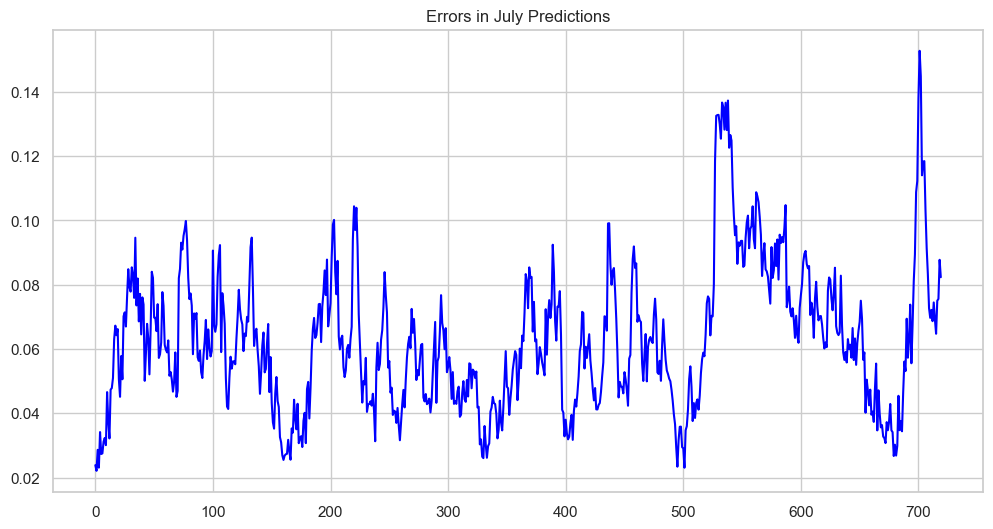

In [ ]:
errors = preds_july_np - true_july_np
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis=0)
abs_errors = np.abs(errors)
abs_error_mean = np.mean(abs_errors, axis=0)
abs_error_std = np.std(abs_errors, axis=0)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(abs_error_mean, label='Mean Error', color='blue')
# plt.fill_between(range(len(abs_error_mean)), abs_error_mean - abs_error_std, abs_error_mean + abs_error_std, color='blue', alpha=0.2)
plt.title('Errors in July Predictions')


In [ ]:
preds_august_np = preds_august_np.T

In [ ]:
pd.DataFrame(preds_august_np).to_csv('predictions/august_predictions.csv', index=False)